citations:
emojifier deep learning.ai

In [50]:
import pandas as pd
import math
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [51]:
dfDataDump = pd.read_csv('/home/archit/Desktop/ad_vs_organic/final_combined_organic_duration3.csv')

In [52]:
dfDataDump = dfDataDump = dfDataDump[dfDataDump['viewCount'] > 2000]

In [53]:
dfDataDump = dfDataDump.sample(n = 2000)

In [54]:
dfDataDump.columns

Index(['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories', 'cleanDescriptions'],
      dtype='object')

In [55]:
dfLen = dfDataDump['cleanDescriptions'].apply(lambda x: len(x.split(' ')))

In [56]:
np.max(dfLen)

565

In [57]:
dfLen.describe()

count    2000.000000
mean      126.499000
std        59.938988
min        10.000000
25%        83.000000
50%       123.000000
75%       159.000000
max       565.000000
Name: cleanDescriptions, dtype: float64

In [58]:
dfDataDump['cleanDescriptions'][0:5]

35327     오버워치 알로직의 플레이 둠피스트 알로직 overwatch fps 처음으로 플레이 ...
57121     lagu anak selamat ulang tahun bersama badut di...
116527    kunal khemu caught stripping newly wedded coup...
32350     shock เดอะช ออกอากาศ มกราคม shock เดอะช อคกดต ...
67561     dalapathi movie scenes rajnikanth marries bhan...
Name: cleanDescriptions, dtype: object

Next we will set up our input dataset and define the function for model training

In [59]:
def input_dataset(dfData, views =0, categories =[], country= ['IN']):
    """manipulates input dataframe according to input parameters.
    Args:
        dfData: input dataset
        views: minimum number of views in dfData.Default = 0.
        categories: list of categories to be present in final dataset.Default is empty list(all categories)
        country: List of countries whose videos should be present in dataSet. Default is India.
    Returns:
        dataset to train model on
    """
    # slice dataset with viewCount larger than views
    dfData = dfData[dfData['viewCount'] >= views]
    # concat dfData according to categories
    categoryIds =(dfData['categoryId'].dropna().unique()).tolist()
    # create temporary df
    tempDf = pd.DataFrame(columns = ['vid', 'channelId', 'duration', 'licensedContent', 'definition',
       'dislikeCount', 'commentCount', 'favoriteCount', 'viewCount',
       'likeCount', 'relevantTopicIds', 'topicIds', 'topicCategories', 'title',
       'description', 'tags', 'categoryId', 'channelTitle', 'publishedAt',
       'Channel Title', 'Channel Description', 'Channel Publish date',
       ' Channel hiddenSubscriberCount', 'Channel viewCount',
       'Channel subscriberCount', 'Channel commentCount', 'Channel videoCount',
       'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'])
    for categoryId in categoryIds:
        df = dfData[dfData['categoryId'] == categoryId]
        keys = []
        keys[0], keys[1] = tempDf['categoryId'][0], df['categoryId'][0]
        tempf = pd.concat([tempDf, df], ignore_index = True, keys = keys)
        
    # select dataframe according to categories
    if len(categories) != 0:
        dfData = tempDf.loc[categories]
    else:
        dfData = tempDf
    
    # choosing countries
    if len(country) != 0:
            dfData = dfData.loc[dfData['Channel country'] == country, ]
    else:
        dfData = dfData.loc[dfData['Channel country'] == 'IN']
        
    return dfData

In [60]:
def preprocessing(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1)
    dfAdStats.rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1)
    dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left')
    dfMergedData = dfMergedData.merge(dfAdStats, on = 'vid', how = 'left')
    return dfMergedData

In [61]:
def preprocessing2(dfData):
    """drops irrelevant features, merges adStats and previous video stats
    Args:
    dfData: input DataSet
    Return:
    merged DataSet
    """
    # drop irrelevant features
    dfData = dfData.drop(['licensedContent', 'relevantTopicIds', 'topicIds', 'topicCategories', 'channelTitle', 'Channel Title', 'Channel Description', ' Channel hiddenSubscriberCount', 'Channel showRelatedChannels', 'Channel featuredChannelsUrls',
       'Channel noOfFeaturedChannels', 'Channel country', 'Channel keywords',
       'Channel topicIds', 'Channel topicCategories'], axis = 1)
    
    # load advertisement and previous stats dataset and clean
    dfAdStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/resultstats.csv').drop(['ch_id','Unnamed: 0'], axis =1)
    dfAdStats.rename(columns = {'video_id':'vid'}, inplace = True)
    dfPrevStats = pd.read_csv('/home/archit/Desktop/ad_vs_organic/previousVideoStats2.csv').drop(['Unnamed: 0'], axis =1)
    dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

    # merge DataSet
    dfMergedData = dfData.merge(dfPrevStats, on = 'vid', how = 'left')
    dfMergedData = dfMergedData.merge(dfAdStats, on = 'vid', how = 'left')
    
    dfMergedData['viewCount'] = dfMergedData['ad%'] * dfMergedData['viewCount']
    return dfMergedData

In [62]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData['Definition'] = dfData['definition'].apply(lambda x: 1 if x=='hd' else 0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [63]:
dfData = preprocessing(dfDataDump)
dfData.columns

Index(['vid', 'channelId', 'duration', 'definition', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'cleanDescriptions',
       'PrevCommentCount', 'PrevDislikeCount', 'PrevLikeCount',
       'PrevPublishedAt', 'PrevViewCount', 'PrevTitle', 'ad%'],
      dtype='object')

In [64]:
dfTrainingData = dfData[dfData['ad%'] == 0]
dfValidationData = dfData[dfData['ad%'] > 0]

In [65]:
df = feature_engineer(dfTrainingData)

In [66]:
df.columns

Index(['vid', 'duration', 'definition', 'dislikeCount', 'commentCount',
       'viewCount', 'likeCount', 'Channel subscriberCount',
       'Channel videoCount', 'cleanDescriptions', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio', 'Definition'],
      dtype='object')

In [67]:
X, y = df.drop('viewCount',axis = 1) , df['viewCount']
X.shape

(1659, 18)

Now we will prepare our cleanDescriptions by encodding and padding them using keras text preprocessing functions

In [68]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

cleanDescriptions = list(X['cleanDescriptions'])
# len of vocabSize should avoid hashing collisions.It is 3541(75% of len of descriptions * 50(50 options for each word))
vocabSize = 3541
encoded_descriptions =  [one_hot(description, vocabSize) for description in cleanDescriptions]

In [69]:
max_length = 161 # we will pad our sequences for 50% of descriptions length
padded_descriptions = pad_sequences(encoded_descriptions, maxlen=max_length, padding='post')

In [70]:
print(len(padded_descriptions))

1659


### Scaling data for applying before to neural nets

In [71]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [72]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [73]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  examples_dataframe["duration"] = log_normalize(examples_dataframe["duration"])
  examples_dataframe["dislikeCount"] = log_normalize(examples_dataframe["dislikeCount"])
  examples_dataframe["commentCount"] = log_normalize(examples_dataframe["commentCount"])
  examples_dataframe["likeCount"] = log_normalize(examples_dataframe["likeCount"])
  examples_dataframe["Channel subscriberCount"] = linear_scale(examples_dataframe["Channel subscriberCount"])
  examples_dataframe["Channel videoCount"] = linear_scale(examples_dataframe["Channel videoCount"])
  examples_dataframe["PrevCommentCount"] = log_normalize(examples_dataframe["PrevCommentCount"])
  examples_dataframe["PrevDislikeCount"] = log_normalize(examples_dataframe["PrevDislikeCount"])
  examples_dataframe["PrevViewCount"] = log_normalize(examples_dataframe["PrevViewCount"])
  examples_dataframe["LikeDislikeRatio"] = linear_scale(examples_dataframe["LikeDislikeRatio"])
  examples_dataframe["channelViewCount"] = log_normalize(examples_dataframe["channelViewCount"])

    
  return examples_dataframe

normalized_dataframe = normalize_linear_scale(X)

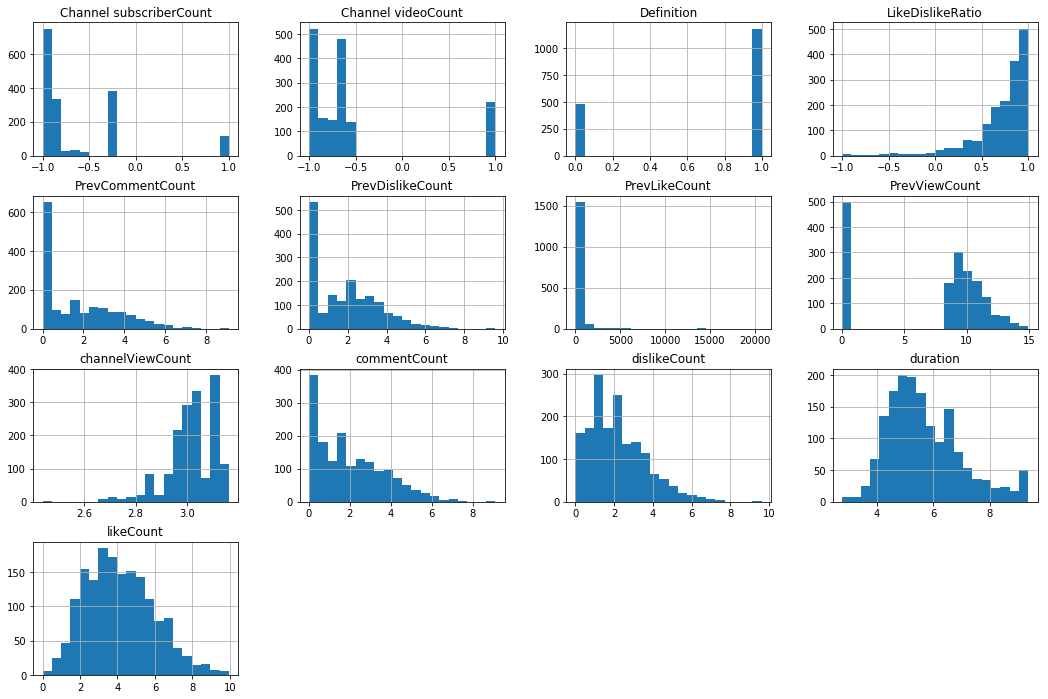

In [74]:
_ = normalized_dataframe.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [75]:
import numpy as np
np.random.seed(0)
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint

np.random.seed(1)

In [76]:
def PREDICT_USING_TEXT_V2(input_shape):
    """
    Function creating the PREDICT_USING_TEXT-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    # Define padded_description as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    padded_descriptions = Input(input_shape, dtype='int32', name = 'main_input')
    
    # Propagate padded_descriptions through embedding layer, you get back the embeddings
    embeddings = Embedding(output_dim=256, input_dim=vocabSize, input_length=max_length)(padded_descriptions)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    lstm_out = LSTM(128, return_sequences=False)(embeddings)
            
    # at this time we feed our auxilary input data by concatenating it with the Lstm output
    auxiliary_input = Input(shape = (15,), name = 'auxiliary_input')
    x = concatenate([lstm_out, auxiliary_input])
    
    # stack a deep densely connected network on top
    x = Dense(256, activation='tanh')(x)
    x = Dense(128, activation='relu')(x)
    x = LeakyReLU(alpha=0.001)(x)
    main_output = Dense(1, name = 'main_output')(x)
    
    
    # define model with two inputs and two outputs
    model = Model(inputs=[padded_descriptions, auxiliary_input], outputs= main_output)
    
    ### END CODE HERE ###
    
    return model

In [77]:
model = PREDICT_USING_TEXT_V2((max_length,))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 161)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 161, 256)     906496      main_input[0][0]                 
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          197120      embedding_2[0][0]                
__________________________________________________________________________________________________
auxiliary_input (InputLayer)    (None, 15)           0                                            
__________________________________________________________________________________________________
concatenat

In [78]:
# optimizer for regression stacking
adam = Adam(lr=0.0002, decay = 0.00001)

In [79]:
model.compile(loss='mean_squared_error', optimizer=adam)

In [80]:
normalized_dataframe.drop(['definition', 'vid', 'cleanDescriptions'], axis=1, inplace=True)

In [81]:
normalized_dataframe.columns

Index(['duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio', 'Definition'],
      dtype='object')

In [82]:
filepath="/home/archit/Desktop/ad_vs_organic/LStM2/organicLoss/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit({'main_input':padded_descriptions, 'auxiliary_input': normalized_dataframe}, {'main_output': y}, epochs = 5000, batch_size = 32, callbacks=callbacks_list, shuffle=True)

Epoch 1/5000
1659/1659 [==============================] - 32s 19ms/step - loss: 50130617809.2441

Epoch 00001: loss improved from inf to 50130617809.24413, saving model to /home/archit/Desktop/ad_vs_organic/LStM2/organicLoss/weights-improvement-01-50130617809.24.hdf5
Epoch 2/5000
1659/1659 [==============================] - 28s 17ms/step - loss: 50128839745.7360

Epoch 00002: loss improved from 50130617809.24413 to 50128839745.73598, saving model to /home/archit/Desktop/ad_vs_organic/LStM2/organicLoss/weights-improvement-02-50128839745.74.hdf5
Epoch 3/5000
1659/1659 [==============================] - 27s 16ms/step - loss: 50126376653.8493

Epoch 00003: loss improved from 50128839745.73598 to 50126376653.84930, saving model to /home/archit/Desktop/ad_vs_organic/LStM2/organicLoss/weights-improvement-03-50126376653.85.hdf5
Epoch 4/5000
1659/1659 [==============================] - 29s 17ms/step - loss: 50123174369.4467

Epoch 00004: loss improved from 50126376653.84930 to 50123174369.44666

KeyboardInterrupt: 

In [ ]:
model.load_weights("/home/archit/Desktop/ad_vs_organic/LStM/weights-improvement-01-3.68.hdf5")

In [ ]:
dfVal = feature_engineer(dfValidationData)

In [60]:
dfValidationData.columns

Index(['vid', 'channelId', 'duration', 'definition', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'Lang',
       'cleanDescriptions', 'PrevCommentCount', 'PrevDislikeCount',
       'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount', 'PrevTitle',
       'ad%'],
      dtype='object')

In [48]:
X_, y = dfVal.drop('viewCount',axis = 1) , np.log(dfVal['viewCount'])


In [49]:
descriptions2 = []
videos = list(X_.vid)
for vid in videos:
    Dict = dfDataDump.loc[dfDataDump['vid'] == vid, 'cleanDescriptions'].to_dict()
    descriptions2.append(getVal(Dict))

In [50]:
descriptions2 = pd.Series(descriptions2)

In [51]:
X_.drop(['definition', 'vid'], axis=1, inplace=True)

In [53]:
X_train_indices2 = sentences_to_indices(descriptions2.values, word_to_index, 703)

In [55]:
result = resume_model.predict({'main_input':X_train_indices2, 'auxiliary_input': X_})

In [58]:
result[0:5]

array([[7.1692953],
       [7.089959 ],
       [7.320867 ],
       [7.1694145],
       [6.950097 ]], dtype=float32)

In [63]:
# function exponentiates values in test_y and pred and
# than calulated rmse of actual views
import math
size = y.shape[0]
test_yL = dfValidationData['viewCount'].tolist()
predL = result.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
for i in range(0, size):
    exActView.append((test_yL[i]))
    exPredView.append(math.exp(predL[i][0]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))

rmse = math.sqrt(sum(sqErr) /size)/(max(exActView) - min(exActView))
dfEval = pd.DataFrame({'vid': dfValidationData['vid'], 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff, 'ad%':dfValidationData['ad%']})
dfEval.head()

,Actual,Diff,Pred,ad%,vid
5,394.0,-904.928939,1298.928939,33.421053,jCnNgHTdbYY
6,254.0,-945.858779,1199.858779,0.406504,iR_gXXK0Q_Q
11,4478.0,2966.486022,1511.513978,70.752984,fIPFc687ink
12,2233.0,933.916207,1299.083793,0.136488,8bLDlaRfp9c
20,54352.0,53308.748994,1043.251006,0.001860,gYd1wqGqZnk


In [64]:
dfEval['Predicted Ad %'] = (dfEval['Diff'])/dfEval['Actual']*100
dfEval.head()

,Actual,Diff,Pred,ad%,vid,Predicted Ad %
5,394.0,-904.928939,1298.928939,33.421053,jCnNgHTdbYY,-229.677396
6,254.0,-945.858779,1199.858779,0.406504,iR_gXXK0Q_Q,-372.385346
11,4478.0,2966.486022,1511.513978,70.752984,fIPFc687ink,66.245780
12,2233.0,933.916207,1299.083793,0.136488,8bLDlaRfp9c,41.823386
20,54352.0,53308.748994,1043.251006,0.001860,gYd1wqGqZnk,98.080566


In [65]:
dfEval[dfEval['Predicted Ad %']<0]=0
dfEval.head()

,Actual,Diff,Pred,ad%,vid,Predicted Ad %
5,0.0,0.000000,0.000000,0.000000,0,0.000000
6,0.0,0.000000,0.000000,0.000000,0,0.000000
11,4478.0,2966.486022,1511.513978,70.752984,fIPFc687ink,66.245780
12,2233.0,933.916207,1299.083793,0.136488,8bLDlaRfp9c,41.823386
20,54352.0,53308.748994,1043.251006,0.001860,gYd1wqGqZnk,98.080566


In [ ]:
# save the model
from keras.models import load_model
model.save('/home/archit/Desktop/ad vs organic/ad_vs_organic_keras_model.h5')

Now we will use standard metrics and evaluate our result

In [66]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [67]:
r2_score(dfEval['ad%'],dfEval['Predicted Ad %'])

-164.78591121628605

In [70]:
np.sqrt(mean_squared_error(dfEval['ad%'],dfEval['Predicted Ad %']))

84.83562740807251

In [72]:
mean_absolute_error(dfEval['ad%'],dfEval['Predicted Ad %'])

79.3856331210703

In [ ]:
bins =int( (dfEval['Diff'].max() - dfEval['Diff'].min())/5)
gh = plt.hist(dfEval['Diff'], bins = bins)
freq, error = gh[0], gh[1]
plt.ylabel('Number of videos')
plt.xlabel('error')
plt.title('Frequiency table of diff in ad%')
plt.show()

In [ ]:
freq = freq.astype('int64')
dfErr = pd.DataFrame()
dfErr['Error'] = pd.Series(error)
dfErr['Frequency'] = pd.Series(freq)
dfErr['Frequency Percentage'] = dfErr['Frequency']/ dfErr['Frequency'].sum() * 100
dfErr

Now we will look for videos with error in prediction > 30 and figure out why.

In [ ]:
dfErr[np.abs(dfErr['Error'])>30]

In [29]:
# Loading ad stats dataset
dfAdStats = pd.read_csv('/home/archit/Desktop/ad vs organic/resultstats.csv')
dfAdStats2 = dfAdStats.drop(['ch_id','Unnamed: 0'], axis =1)
dfAdStats2.rename(columns = {'video_id':'vid'}, inplace = True)
dfAdStats2.shape

(246184, 2)

In [41]:
# Loading perv stats dataset
dfPrevStats = pd.read_csv('/home/archit/Desktop/ad vs organic/previousVideoStats2.csv')
dfPrevStats = dfPrevStats.drop(['Unnamed: 0'], axis =1)
dfPrevStats.rename(columns = {'Id':'vid'}, inplace = True)

dfPrevStats.head()

,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,vid
0,9.0,5.0,112.0,2016-08-25T03:48:52.000Z,21007.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 13 - Hà...,NaN
1,7.0,6.0,77.0,2016-11-15T06:59:55.000Z,19326.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 14 - Kh...,LPqCSwCNI5w
2,28.0,12.0,109.0,2016-11-15T07:01:46.000Z,33071.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 17 - Gi...,0LGl5jbnrlU
3,8.0,9.0,84.0,2016-11-15T07:01:55.000Z,29516.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 18 - C...,jFFSYwdku9M
4,12.0,18.0,145.0,2016-11-15T07:02:03.000Z,49653.0,Nhỏ To Cùng Mẹ | Nhật Ký Bí Bầu | Tuần 19 - Ăn...,HvFNGb-nrRU


### Merging Dataset

In [42]:
dfMergedData = dfData2.merge(dfPrevStats, on = 'vid', how = 'left')
dfMergedData = dfMergedData.merge(dfAdStats2, on = 'vid', how = 'left')

In [43]:
dfMergedData.columns

Index(['Unnamed: 0', 'vid', 'channelId', 'duration', 'dislikeCount',
       'commentCount', 'favoriteCount', 'viewCount', 'likeCount', 'title',
       'description', 'tags', 'categoryId', 'publishedAt',
       'Channel Publish date', 'Channel viewCount', 'Channel subscriberCount',
       'Channel commentCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevPublishedAt', 'PrevViewCount',
       'PrevTitle', 'ad%'],
      dtype='object')

In [44]:
dfMergedData.to_csv("/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv")

In [45]:
dfMergedData = pd.read_csv('/home/archit/Desktop/ad vs organic/merged_data_ad_vs_org.csv')

### Picking up traininig set and validation set

In [46]:
dfTrainingSet = dfMergedData.loc[dfMergedData['ad%'] == 0,]
dfTrainingSet.shape

(112873, 27)

In [47]:
dfValidationSet = dfMergedData.loc[dfMergedData['ad%']>0, ]

dfValidationSet.shape

(8003, 27)

dfTrainingSet.to_csv("/home/archit/Desktop/ad vs organic/training_data_ad_vs_org3.csv")


In [48]:
dfValidationSet['orgViews'] = dfValidationSet['viewCount']*(100-dfValidationSet['ad%'])

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
dfValidationSet.drop('viewCount', axis=1, inplace= True)
dfValidationSet.rename(columns = {'orgViews':'viewCount'}, inplace = True)

/home/archit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/archit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [23]:
dfTrainingSet = pd.concat([dfTrainingSet, dfValidationSet], ignore_index = True)

In [24]:
dfTrainingSet.shape

(36515, 26)

In [25]:
dfValidationSet.to_csv('/home/archit/Desktop/ad vs organic/validation_data_ad_vs_org3.csv')

### Feature engineering


In [50]:
def feature_engineer(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount', 'categoryId'],axis =1)
    
    
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['PrevCommentCount'] = dfData['PrevCommentCount'].fillna(0)
    dfData['PrevDislikeCount'] = dfData['PrevDislikeCount'].fillna(0)
    dfData['PrevLikeCount'] = dfData['PrevLikeCount'].fillna(0)
    dfData['PrevViewCount'] = dfData['PrevViewCount'].fillna(0)   
    dfData['duration'] = dfData['duration'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].fillna(0)
    dfData['Channel subscriberCount'] = dfData['Channel subscriberCount'].fillna(0)
    dfData = dfData.drop(['title','description','publishedAt','Channel viewCount','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [51]:
def feature_engineer2(dfData):
    dfData =dfData.drop(['favoriteCount', 'PrevTitle', 'PrevPublishedAt', 'Channel commentCount'],axis =1)
    
    dfData = dfData.dropna()
    dfData['PublishedYear'] = dfData['publishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['Channel Publish date'].apply(lambda x: x[:4])
    dfData['channelViewCount'] = np.log(dfData['Channel viewCount'])
    dfData['LikeDislikeRatio'] = dfData['likeCount']/(dfData['dislikeCount'] + dfData['likeCount'])
    dfData['LikeDislikeRatio'] = dfData['LikeDislikeRatio'].replace(np.inf, np.nan)
    dfData = dfData.drop(['title','description','publishedAt','','Channel Publish date','channelId','tags', 'ad%'],axis = 1)
    
    return dfData

def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData

In [52]:
df = feature_engineer(dfTrainingSet)
#df.to_csv('/home/archit/Desktop/ad vs organic/trainSet2.csv')

In [61]:
X, y = df.drop('viewCount',axis = 1) , np.log(df['viewCount'])
X = X.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
X.shape

ValueError: labels ['Unnamed: 0' 'Unnamed: 0.1'] not contained in axis

In [69]:
X.columns

Index(['vid', 'duration', 'dislikeCount', 'commentCount', 'likeCount',
       'Channel subscriberCount', 'Channel videoCount', 'PrevCommentCount',
       'PrevDislikeCount', 'PrevLikeCount', 'PrevViewCount', 'PublishedYear',
       'ChannelAge', 'channelViewCount', 'LikeDislikeRatio'],
      dtype='object')

In [55]:
#X.to_csv('/home/archit/Desktop/ad vs organic/trainSET.csv')

### Modeling

In [70]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#from xgboost import XGBClassifier, XGBRegressor

In [71]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.75, test_size = 0.25)

train_X_id, train_X = train_X.vid, train_X.drop('vid', axis = 1)
test_X_id, test_X = test_X.vid, test_X.drop('vid', axis = 1)

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

import pickle
pickle.dump(reg, open("Gbr005.pickle.dat", "wb"))

In [72]:
pred = reg.predict(test_X)

In [73]:
size = test_y.shape[0]
test_yL = test_y.tolist()
predL = pred.tolist()
exActView = []
exPredView = []
diff = []
sqErr = []
mape={}
for i in range(0, size):
    exActView.append(math.exp(test_yL[i]))
    exPredView.append(math.exp(predL[i]))
    diff.append(exActView[i] - exPredView[i])
    sqErr.append(math.pow(diff[i], 2))
rmse = math.sqrt(sum(sqErr) /size)/ (test_y.max() - test_y.min())
dfEval = pd.DataFrame({'Id':test_X_id, 'Actual' : exActView, 'Pred': exPredView, 'Diff': diff})
dfEval.head()

,Actual,Diff,Id,Pred
44138,411.0,101.860164,lhpiPhfw8m8,309.139836
31600,881.0,-105.292991,2DEfSW3e3Hg,986.292991
27166,533.0,-201.823546,ZlBuyx8qz64,734.823546
67319,3926.0,1070.292623,fM38i1eHr98,2855.707377
42187,385.0,200.500859,_R4DWeJhz7Y,184.499141


In [74]:
print("Rmse of the regressormodel is:" + str(rmse))

Rmse of the regressormodel is:2387.4454790550158


In [75]:
1011.0650776175543/dfEval['Actual'].mean()

0.04029664809978987

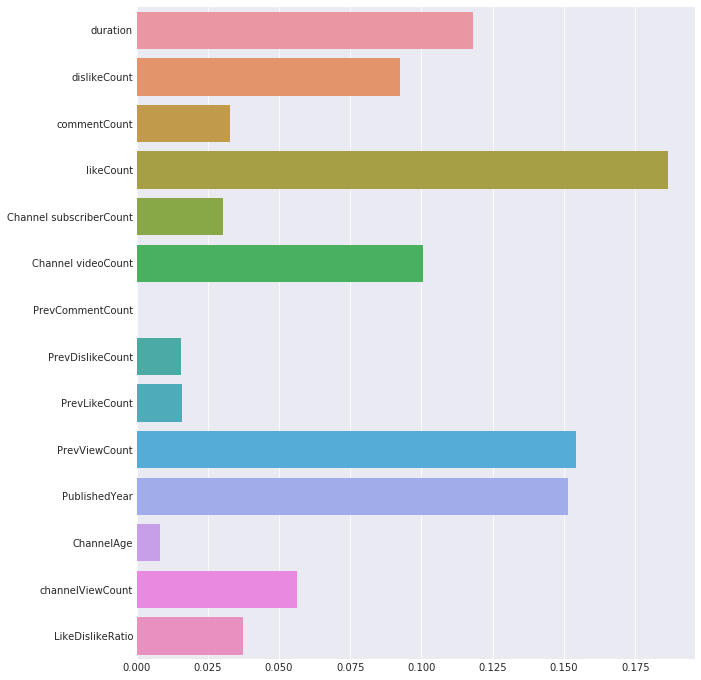

In [76]:
X = X.drop('vid', axis = 1)
sns.set_style('darkgrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

### Modeling on validation set

In [91]:
df = feature_engineer(dfValidationSet)